# Lab Assignment 1

## Austin Booth

### Exercise 1

In [11]:
import tclab

print("Version = ", tclab.__version__)
tclab.diagnose()

Version =  0.4.9

Checking connection
-------------------
Looking for Arduino on any port...
Arduino Leonardo found on port COM6

Testing TCLab object in debug mode
----------------------------------
TCLab version 0.4.9
Sent: "Q1 0"
Return: "0.000"
Sent: "VER"
Return: "TCLab Firmware 2.0.1 Arduino Leonardo/Micro"
Arduino Leonardo connected on port COM6 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
Sent: "Q2 0"
Return: "0.000"
Reading temperature
Sent: "T1"
Return: "27.666"
27.666
Sent: "Q1 0"
Return: "0.000"
Sent: "Q2 0"
Return: "0.000"
Sent: "X"
Return: "Stop"
TCLab disconnected successfully.

Testing TCLab functions
-----------------------
TCLab version 0.4.9
Arduino Leonardo connected on port COM6 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
Testing LED. Should turn on for 10 seconds.
Countdown: 0  

Reading temperatures
T1 = 27.988 °C, T2 = 27.988 °C

Writing fractional value to heaters...
We wrote Q1 = 0.5, and read back Q1 = 0.5

We will now turn on

### Exercise 2

TCLab version 0.4.9
Arduino Leonardo connected on port COM6 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.


<IPython.core.display.Javascript object>


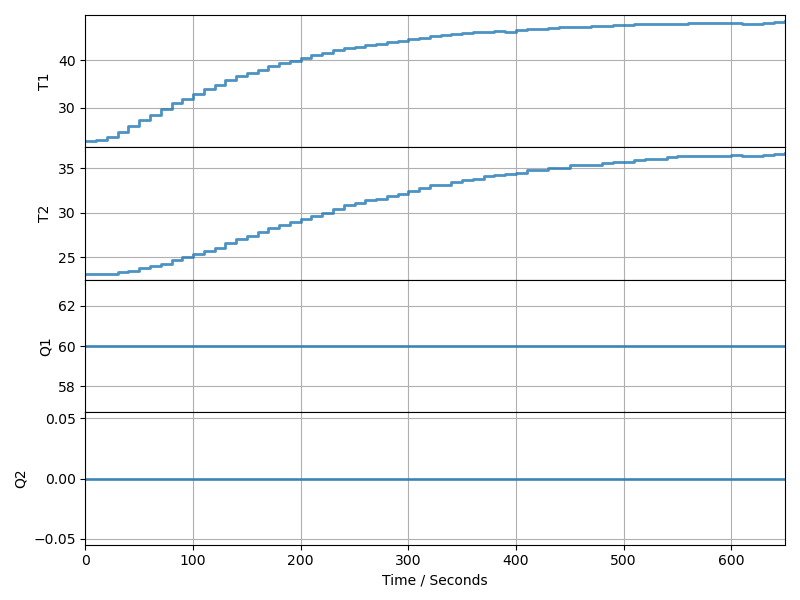

TCLab disconnected successfully.


In [14]:
%matplotlib notebook

from tclab import TCLab, clock, Historian, Plotter

with TCLab() as lab:
    h = Historian(lab.sources)
    p = Plotter(h, 650)
    for t in clock(650, 10):
        lab.Q1(60)
        p.update(t)
        
h.to_csv('data.csv')

,T1,T2,Q1,Q2
Time,,,,
0.00,22.832,23.154,60.0,0.0
10.00,23.058,23.154,60.0,0.0
20.02,23.799,23.187,60.0,0.0
30.02,24.766,23.380,60.0,0.0
40.01,26.055,23.477,60.0,0.0
...,...,...,...,...
610.00,47.582,36.367,60.0,0.0
620.02,47.646,36.367,60.0,0.0
630.00,47.969,36.561,60.0,0.0


<AxesSubplot:xlabel='time / seconds'>

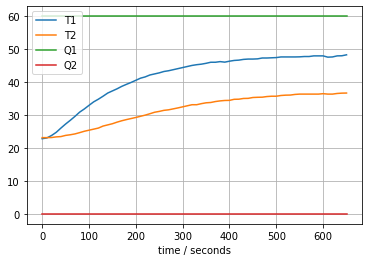

In [15]:
# import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# create data file
expt = pd.read_csv('data.csv')

# set time index
expt = expt.set_index("Time")
t_expt = expt.index

# display data in tabular format
display(expt)

# simple plotting
expt.plot(grid=True, xlabel="time / seconds")

### Exercise 3

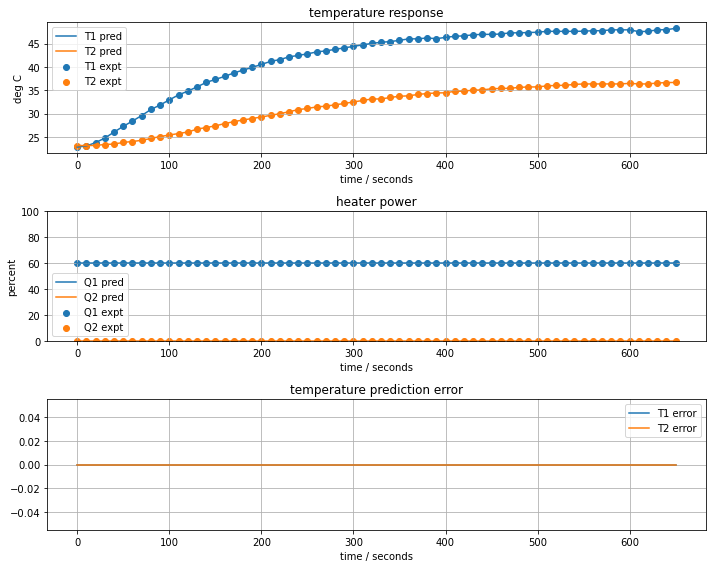

In [16]:
# create a function to compare two data sets
def plot_data(expt, pred):
    t_expt = expt.index
    
    # create a 3 x 1 grid of plot axes
    fig, ax = plt.subplots(3, 1, figsize=(10,8))
    
    # first plot axes
    ax[0].scatter(t_expt, expt["T1"], label="T1 expt")
    ax[0].scatter(t_expt, expt["T2"], label="T2 expt")
    ax[0].plot(t_expt, pred["T1"], label="T1 pred")
    ax[0].plot(t_expt, pred["T2"], label="T2 pred")
    ax[0].set_ylabel("deg C")
    ax[0].set_title("temperature response")

    # second plot axes
    ax[1].scatter(t_expt, expt["Q1"], label="Q1 expt")
    ax[1].scatter(t_expt, expt["Q2"], label="Q2 expt")
    ax[1].plot(t_expt, pred["Q1"], label="Q1 pred")
    ax[1].plot(t_expt, pred["Q2"], label="Q2 pred")
    ax[1].set_ylim([0, 100])
    ax[1].set_ylabel("percent")
    ax[1].set_title("heater power")
    
    # third plot axes
    ax[2].plot(t_expt, pred["T1"]-expt["T1"], label="T1 error")
    ax[2].plot(t_expt, pred["T2"]-expt["T2"], label="T2 error")
    ax[2].set_title("temperature prediction error")
    
    # things to do for every plot axes
    for a in ax:
        a.grid(True)
        a.set_xlabel("time / seconds")
        a.legend()
        
    plt.tight_layout()
    
    # return list of axes so to allow additional information to be added
    return ax
    
# demonstrate by comparing experimental data to itself
plot_data(expt, expt);

array([<AxesSubplot:title={'center':'temperature response'}, xlabel='time / seconds', ylabel='deg C'>,
       <AxesSubplot:title={'center':'heater power'}, xlabel='time / seconds', ylabel='percent'>,
       <AxesSubplot:title={'center':'temperature prediction error'}, xlabel='time / seconds'>],
      dtype=object)

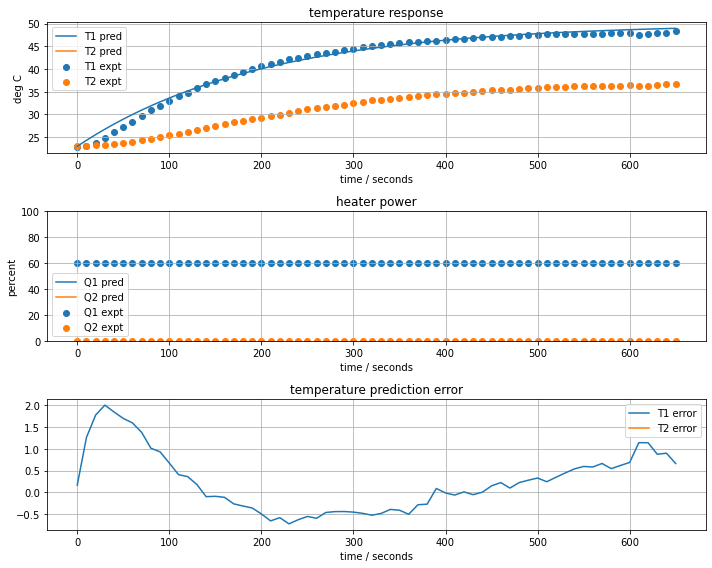

In [50]:
# set ambient temperature based on starting temperature of approximately 23 C
T_amb = 23
u1bar = expt["Q1"].mean()

# first, estimate K and tau by looking at model.
# gain can be estimated by deltaT / % power = (25 C)/(60 %) = approx. 0.42
# half-life appears to be around 150 seconds (time to reach 1/2 the temperature change)
# tau estimated as 150 / ln(2) = 220 s

# adjustable model parameters; these were fit by trial and error using initial estimates.
K = 0.45
tau = 200

# create a prediction
pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
pred["T1"] = T_amb + K*u1bar*(1 - np.exp(-t_expt/tau))

# compare prediction to experiment
plot_data(expt, pred)

[  0.44710997 199.99998815]


33.961648534366105

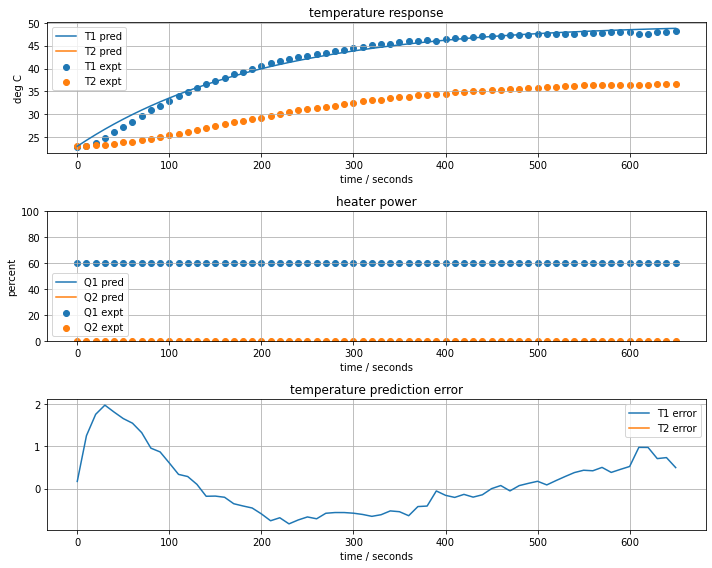

In [51]:
# use optimization function to confirm estimate of K and tau
param = [K, tau]

def model_gain_timeconstant(param, plot=False):
    K, tau = param
    
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T1"] = T_amb + K*u1bar*(1 - np.exp(-t_expt/tau))
    
    # compute sum of squares error
    err = ((pred["T1"] - expt["T1"])**2).sum()
    
    if plot:
        plot_data(expt, pred)
        
    return err
        
# optimize using least squares
from scipy.optimize import least_squares

# plot and return results
result = least_squares(model_gain_timeconstant, param)
print(result.x)
model_gain_timeconstant(result.x, plot=True)

In [52]:
# calculate half-life from time constant
# t1/2 = -(time constant)*ln(0.5)
t_half = -result.x[1]*np.log(0.5)

# print results
print('Approximate Parameters')
print('Time constant:', round(result.x[1]),'seconds')
print('Half-life:', round(t_half),'seconds')
print('Gain:', round(result.x[0],2),'degrees C / % power')

Approximate Parameters
Time constant: 200 seconds
Half-life: 139 seconds
Gain: 0.45 degrees C / % power


### Exercise 4

The response in heater 2 does not appear to be the response of a first-order linear system. There is a considerable lag in temperature increase, where the slope of the response starts off low and then increases before leveling off. In a first-order system, we would expect an immediate response where the slope consistently decreases over time.

The gain for heater 2 can still be estimated by dividing the temperature increase by percent power; 

(36 C - 23 C) / 60% = 0.22 degrees C / % power = K.

We can check this estimate by applying it to a prediction in the following cell. The gain of 0.22 C/% appears to fit the data fairly well with a time constant of 200 seconds, but the initial lag in the data is severely overestimated by the first-order model.

array([<AxesSubplot:title={'center':'temperature response'}, xlabel='time / seconds', ylabel='deg C'>,
       <AxesSubplot:title={'center':'heater power'}, xlabel='time / seconds', ylabel='percent'>,
       <AxesSubplot:title={'center':'temperature prediction error'}, xlabel='time / seconds'>],
      dtype=object)

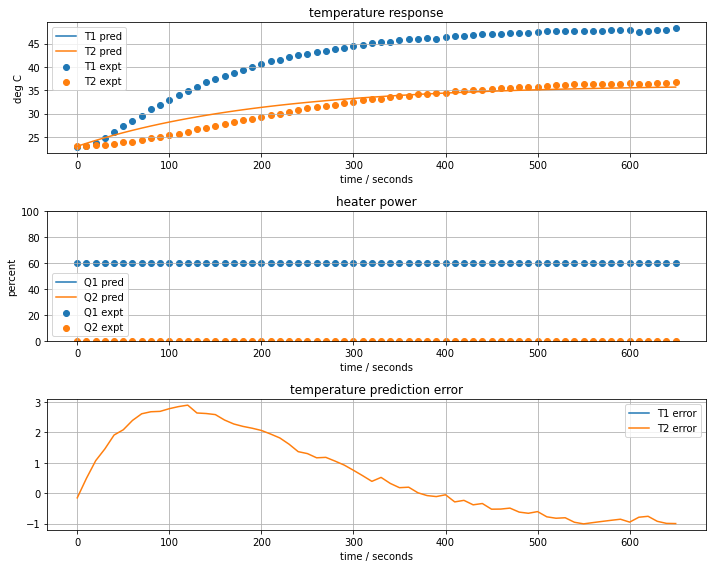

In [57]:
# set ambient temperature based on starting temperature of approximately 23 C
T_amb = 23
u1bar = expt["Q1"].mean()

# adjustable model parameters
K = 0.22
tau = 200

# create a prediction
pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
pred["T2"] = T_amb + K*u1bar*(1 - np.exp(-t_expt/tau))

# compare prediction to experiment
plot_data(expt, pred)